# Week 1

### Background

Top consulting companies such as Ernest & Young, Delloite, Pricewater coopers, Boston Consulting, KPMG hire consultants to work at their client locations. During the period of their assignment, they travel to these client locations from their homes and stay in hotels and eat out. All these boarding and lodging expenses are reimbursed by the consulting company. The consulting company interns would have accounted for all these expenses in finalizing the billing rate with the client. In the interest and safety of their consultants, the company allows their consultant to stay best and safe locations regardless of the daily hotel rate.

### Business Problem

Since consultants have to stay near client location, it is good idea for the consulting companies to identify safe and nearby hotels and write a contract with the hotels. That way, the consulting company can get a better rate and pass those savings to the client to be competitive with other competing companies. It also provides a comfort to the consultants because they are staying at preferred hotels.

We are going to apply data science technology to identify best and safe hotels in New York 


### Data

We would be using 
1.	New York City Data containing Boroughs, Neighborhoods along with their latitude and longitude
a.	Data Source: https://cocl.us/new_york_dataset
2.	New York City crime data
a.	Data Source:  https://data.cityofnewyork.us/resource/5uac-w243.json
3.	Hotel data using Foursquare API 
4.	GeoSpace data to draw / visualize choropleth map
a.	Data Source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm & https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz
5.	Top 50 Neighbourhoods in Newyork
a.	https://www.dnainfo.com/crime-safety-report/ranking
6.	Precincts data for Newyork
a.	https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page


# Week 2

In [189]:
import io
import requests
import pandas as pd
import numpy as np
from requests import request
import random # library for random number generation
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import geocoder
import os

In [190]:
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

In [191]:
!conda install pip --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [192]:
import matplotlib.pyplot as plt;plt.rcdefaults()
plt.close('all')
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

In [193]:
!conda install -c conda-forge folium --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium.plugins import FastMarkerCluster

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         208 KB

The following packages will be UPDATED:

    certifi: 2019.6.16-py36_1              --> 2019.6.16-py36_1  conda-forge
    folium:  0.5.0-py_0        conda-forge --> 0.10.0-py_0       conda-forge

The following packages will be DOWNGRADED:

In [195]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="battle of neighbourhoods")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



# New York Borough and Neighbourhood data
It was obtained from Data Source: https://cocl.us/new_york_dataset
The data file was dowloaded in previous iterations and saved locally for processing. A copy of this is loaded in https://github.com/malthippana/Coursera_Capstone

In [196]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
newyork_borough_df = pd.read_csv('newyork_borough_data.csv', delimiter=',', names = column_names,header=0 )
newyork_borough_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [197]:
newyork_borough_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
Borough         306 non-null object
Neighborhood    306 non-null object
Latitude        306 non-null float64
Longitude       306 non-null float64
dtypes: float64(2), object(2)
memory usage: 9.7+ KB


# New York Crime data
It was obtained from NYPD database:  https://data.cityofnewyork.us/resource/5uac-w243.json
The data file was dowloaded in previous iterations and saved locally for processing. A copy of this data is saved in https://github.com/malthippana/Coursera_Capstone

For the sake of fast processing, I applied some filters and dropped rows

In [198]:
newyork_crimes_df = pd.read_csv('newyork_crime_data.csv',delimiter=',', header=0 )
newyork_crimes_df.head()

,Precincts,Borough,Crime,Latitude,Longitude
0,10,Manhattan,"ASSAULT 2,1,UNCLASSIFIED",40.747777,-74.000398
1,101,Queens,"BURGLARY,RESIDENCE,DAY",40.598538,-73.748560
2,41,Bronx,"ROBBERY,BEGIN AS SHOPLIFTING",40.819886,-73.901227
3,68,Brooklyn,"CONTROLLED SUBSTANCE,INTENT TO",40.624663,-73.999321
4,45,Bronx,ASSAULT 3,40.838545,-73.844583


<Figure size 1500x500 with 0 Axes>

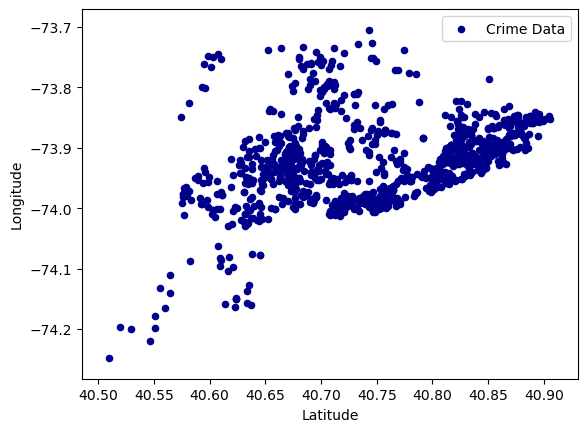

In [199]:
plt.figure(figsize=(15,5), dpi = 100)
ax = newyork_crimes_df.plot.scatter(x='Latitude', y='Longitude', color='DarkBlue', label='Crime Data');

#### Pre-process Crime data 
Though the input file contains YTD crime data, for the sake of this test, I am dropping all data and only taking crime data from 06/01/2019 

In [200]:
crime_data_by_Borough = newyork_crimes_df.groupby(['Borough']).size().reset_index(name='Count')
crime_data_by_Borough.head()

,Borough,Count
0,Bronx,277
1,Brooklyn,296
2,Manhattan,235
3,Queens,157
4,Staten Island,30


In [251]:
crime_data_by_Borough.sort_values(['Count'],ascending=False).head()

,Borough,Count
1,Brooklyn,296
0,Bronx,277
2,Manhattan,235
3,Queens,157
4,Staten Island,30


In [201]:
crime_data_by_Precincts = newyork_crimes_df.groupby(['Precincts']).size().reset_index(name='Count')
crime_data_by_Precincts.head()

,Precincts,Count
0,1,10
1,5,15
2,6,3
3,7,6
4,9,10


In [202]:
crime_data_by_Precincts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
Precincts    76 non-null int64
Count        76 non-null int64
dtypes: int64(2)
memory usage: 1.3 KB


In [203]:
crime_data_by_Precincts.describe(include='all')

,Precincts,Count
count,76.000000,76.000000
mean,63.868421,13.092105
std,36.039734,8.089792
min,1.000000,3.000000
25%,32.750000,7.000000
50%,66.500000,11.000000
75%,100.250000,15.250000
max,123.000000,41.000000


In [204]:
crime_data_by_Precincts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
Precincts    76 non-null int64
Count        76 non-null int64
dtypes: int64(2)
memory usage: 1.3 KB


<Figure size 900x500 with 0 Axes>

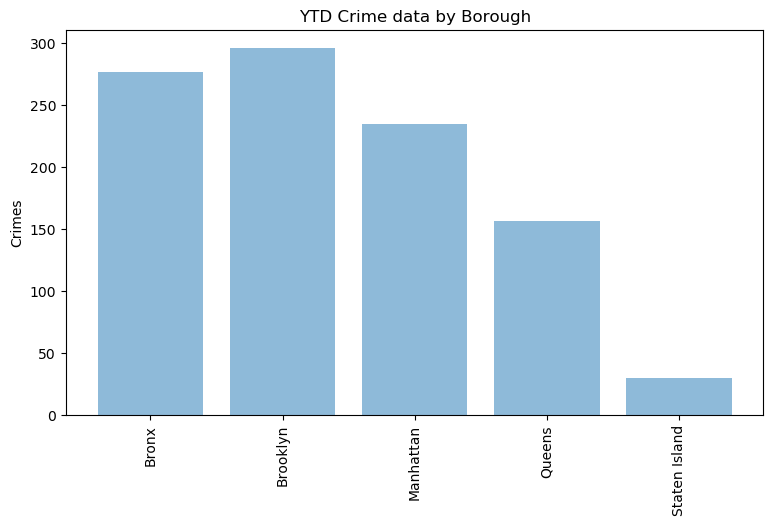

In [205]:
plt.figure(figsize=(9,5), dpi = 100)
plt.figure(figsize=(9,5), dpi = 100)
y_pos = np.arange(len(crime_data_by_Borough['Borough']))
plt.bar(y_pos, crime_data_by_Borough['Count'], align='center', alpha=0.5)
plt.xticks(y_pos, crime_data_by_Borough['Borough'], rotation='vertical')
plt.ylabel('Crimes')
plt.title('YTD Crime data by Borough')
plt.show()

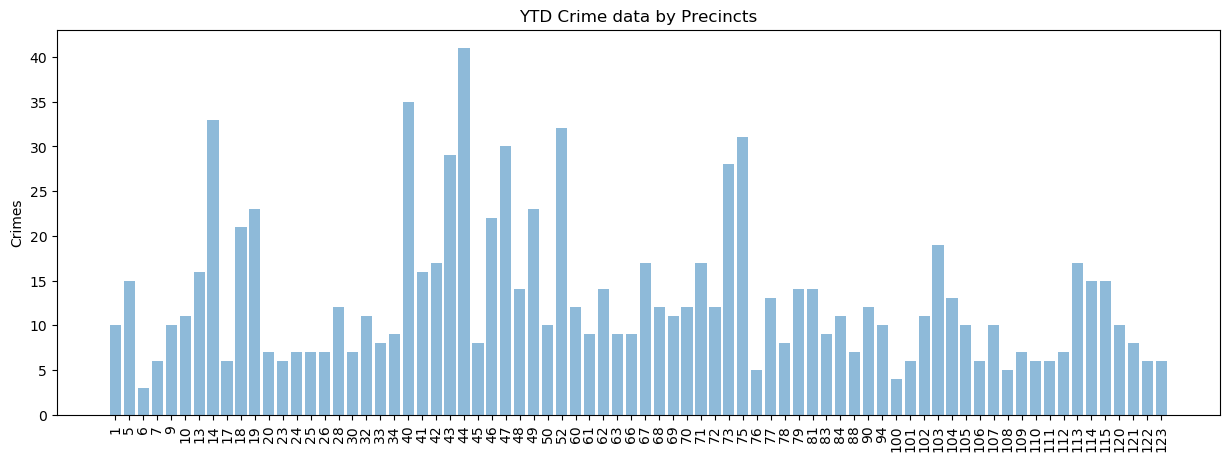

In [206]:
plt.figure(figsize=(15,5), dpi = 100)
y_pos = np.arange(len(crime_data_by_Precincts['Precincts']))
plt.bar(y_pos, crime_data_by_Precincts['Count'], align='center', alpha=0.5)
plt.xticks(y_pos, crime_data_by_Precincts['Precincts'], rotation='vertical')
plt.ylabel('Crimes')
plt.title('YTD Crime data by Precincts')
plt.show()

# Read TOP 50 Neighbourhood areas in New York
It was obtained by curating the data from https://www.dnainfo.com/crime-safety-report/ranking. 
The data file was dowloaded in previous iterations and saved locally for processing. A copy of this data is saved in https://github.com/malthippana/Coursera_Capstone

In [207]:
safe_neighborhoods_df = pd.read_csv('NY_top_50_safe_neighbourhoods.csv', delimiter=',', header=0 )
safe_neighborhoods_df.columns = ['Rank', 'Neighborhood', 'Borough', 'Precincts'] 
safe_neighborhoods_df.head()

,Rank,Neighborhood,Borough,Precincts
0,35.0,Wakefield,Bronx,47.0
1,28.0,Co-op City,Bronx,45.0
2,35.0,Eastchester,Bronx,47.0
3,13.0,Fieldston,Bronx,50.0
4,13.0,Riverdale,Bronx,50.0


In [208]:
safe_neighborhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
Rank            188 non-null float64
Neighborhood    306 non-null object
Borough         306 non-null object
Precincts       189 non-null float64
dtypes: float64(2), object(2)
memory usage: 9.7+ KB


## Select Borough & Neighbourhoods for identifying hotels
### Conditions 
#### 1. Should be in top 50 safe rank neighbourhoods
#### 2. The crime count should be less than the mean of the total neighbourhood count

In [209]:
safe_neighborhoods_df.dropna(subset=['Rank'], inplace=True)
safe_neighborhoods_df.Rank = safe_neighborhoods_df.Rank.astype('int')
safe_neighborhoods_df.drop(safe_neighborhoods_df[safe_neighborhoods_df.Rank  > 50].index, inplace=True)
safe_neighborhoods_df.Precincts = safe_neighborhoods_df.Precincts.astype('int')
safe_neighborhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 0 to 293
Data columns (total 4 columns):
Rank            155 non-null int64
Neighborhood    155 non-null object
Borough         155 non-null object
Precincts       155 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.1+ KB


In [211]:
safe_neighborhoods_df.head()

,Rank,Neighborhood,Borough,Precincts
0,35,Wakefield,Bronx,47
1,28,Co-op City,Bronx,45
2,35,Eastchester,Bronx,47
3,13,Fieldston,Bronx,50
4,13,Riverdale,Bronx,50


In [212]:
mean_df = crime_data_by_Precincts.mean()
mean_crime_val = mean_df.Count
print (mean_crime_val)
Precincts_with_less_crime_count_df = crime_data_by_Precincts.drop(crime_data1[crime_data_by_Precincts.Count  > mean_crime_val].index)
Precincts_with_less_crime_count_df.head(10)

13.092105263157896


,Precincts,Count
0,1,10
2,6,3
3,7,6
4,9,10
5,10,11
8,17,6
11,20,7
12,23,6
13,24,7
14,25,7


In [213]:
Precincts_with_less_crime_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 75
Data columns (total 2 columns):
Precincts    50 non-null int64
Count        50 non-null int64
dtypes: int64(2)
memory usage: 1.2 KB


In [214]:
# Now we are mapping the Precincts to Precincts in top 50 safe neighbourhoods
safe_neighborhoods_df['Precincts'].isin(Precincts_with_less_crime_count_df['Precincts']).value_counts()
top_neighbourhoods_with_less_crime_df = (safe_neighborhoods_df[safe_neighborhoods_df.Precincts.isin(Precincts_with_less_crime_count_df.Precincts)])
top_neighbourhoods_with_less_crime_df.head()

,Rank,Neighborhood,Borough,Precincts
1,28,Co-op City,Bronx,45
3,13,Fieldston,Bronx,50
4,13,Riverdale,Bronx,50
5,13,Kingsbridge,Bronx,50
6,13,Marble Hill,Manhattan,50


In [215]:
top_neighbourhoods_with_less_crime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 1 to 293
Data columns (total 4 columns):
Rank            124 non-null int64
Neighborhood    124 non-null object
Borough         124 non-null object
Precincts       124 non-null int64
dtypes: int64(2), object(2)
memory usage: 4.8+ KB


In [216]:
selected_neighbourhoods_df = (newyork_borough_df[newyork_borough_df.Neighborhood.isin(top_neighbourhoods_with_less_crime_df.Neighborhood)])
selected_neighbourhoods_df.head()

,Borough,Neighborhood,Latitude,Longitude
1,Bronx,Co-op City,40.874294,-73.829939
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660


In [217]:
selected_neighbourhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 1 to 293
Data columns (total 4 columns):
Borough         127 non-null object
Neighborhood    127 non-null object
Latitude        127 non-null float64
Longitude       127 non-null float64
dtypes: float64(2), object(2)
memory usage: 5.0+ KB


In [218]:
export_csv = selected_neighbourhoods_df.to_csv (r'selected_neighbourhoods_data.csv', index = None, header=True) 

# Hotels in New York Borough / Neighbourhood area
It was obtained from Foursqure API: https://api.foursquare.com/v2/venues/search
The data file was dowloaded in previous iterations and saved locally for processing. A copy of this data is saved in https://github.com/malthippana/Coursera_Capstone

In [330]:
newyork_hotels_df = pd.read_csv('newyork_hotels_data.csv', delimiter=',', header=0 )
newyork_hotels_df.head()

,Borough,Neighbourhood,Hotel_ID,Hotel_Name,Category_NM,Category_ID,Latitude,Longtude
0,Bronx,Co-op City,54932887498ee0902b1ed511,Residence Inn by Marriott New York The Bronx a...,Hotel,4bf58dd8d48988d1fa931735,40.850020,-73.842579
1,Bronx,City Island,54932887498ee0902b1ed511,Residence Inn by Marriott New York The Bronx a...,Hotel,4bf58dd8d48988d1fa931735,40.850020,-73.842579
2,Bronx,Throgs Neck,54932887498ee0902b1ed511,Residence Inn by Marriott New York The Bronx a...,Hotel,4bf58dd8d48988d1fa931735,40.850020,-73.842579
3,Bronx,Pelham Bay,54932887498ee0902b1ed511,Residence Inn by Marriott New York The Bronx a...,Hotel,4bf58dd8d48988d1fa931735,40.850020,-73.842579
4,Brooklyn,Greenpoint,4ab04eb9f964a520fe6620e3,The Bowery Hotel,Hotel,4bf58dd8d48988d1fa931735,40.726145,-73.991627


In [331]:
newyork_hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
Borough          41 non-null object
Neighbourhood    41 non-null object
Hotel_ID         41 non-null object
Hotel_Name       41 non-null object
Category_NM      41 non-null object
Category_ID      41 non-null object
Latitude         41 non-null float64
Longtude         41 non-null float64
dtypes: float64(2), object(6)
memory usage: 2.7+ KB


In [332]:
newyork_hotels_df.dropna(inplace=True)
newyork_hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 8 columns):
Borough          41 non-null object
Neighbourhood    41 non-null object
Hotel_ID         41 non-null object
Hotel_Name       41 non-null object
Category_NM      41 non-null object
Category_ID      41 non-null object
Latitude         41 non-null float64
Longtude         41 non-null float64
dtypes: float64(2), object(6)
memory usage: 2.9+ KB


In [334]:
print(newyork_hotels_df.Neighbourhood.unique())

['Co-op City' 'City Island' 'Throgs Neck' 'Pelham Bay' 'Greenpoint'
 'Williamsburg' 'Cobble Hill' 'Carroll Gardens' 'Red Hook'
 'East Williamsburg' 'Upper West Side' 'Chelsea' 'Woodside' 'Sunnyside'
 'South Ozone Park' 'Springfield Gardens' 'Rosedale' 'Rockaway Beach'
 "Mariner's Harbor" 'Port Ivory' 'New Springville' 'Travis' 'Westerleigh'
 'Graniteville' 'Arlington' 'Bloomfield' 'Bulls Head' 'Elm Park'
 'Turtle Bay' 'Willowbrook']


In [335]:
hotels_by_neighbourhood_df = newyork_hotels_df.groupby(['Borough','Neighbourhood']).size().reset_index(name='Count')
hotels_by_neighbourhood_df.head(20)

,Borough,Neighbourhood,Count
0,Bronx,City Island,1
1,Bronx,Co-op City,1
2,Bronx,Pelham Bay,1
3,Bronx,Throgs Neck,1
4,Brooklyn,Carroll Gardens,1
5,Brooklyn,Cobble Hill,2
6,Brooklyn,East Williamsburg,2
7,Brooklyn,Greenpoint,2
8,Brooklyn,Red Hook,1
9,Brooklyn,Williamsburg,2


### Draw scatter plot of Hotels & Crimes locations using Latitudes and Longitudes to see the proximity 

<Figure size 5760x2880 with 0 Axes>

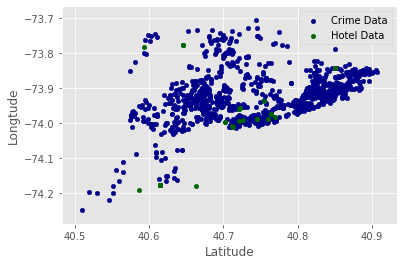

In [337]:
plt.figure(figsize=(80,40))
ax = newyork_crimes_df.plot.scatter(x='Latitude', y='Longitude', color='DarkBlue', label='Crime Data');
newyork_hotels_df.plot.scatter(x='Latitude', y='Longtude', color='DarkGreen', label='Hotel Data', ax=ax);

In [348]:
LATITUDE = 40.730610
LONGITUDE =  -73.93524
# ny_map = folium.Map(location=[LATITUDE,LONGITUDE], zoom_start=8,tiles='OpenStreetMap')
hotels_map = folium.Map(location=[LATITUDE,LONGITUDE], zoom_start=12)

In [349]:
hotels_map

In [350]:
#ny_map1 = folium.Map(location=[LATITUDE,LONGITUDE], zoom_start=12)
crime_data_by_Precincts.Precincts = crime_data_by_Precincts.Precincts.astype('str')
precincts_geo = r'Police_Precincts.geojson'

hotels_map.choropleth(
    geo_data=precincts_geo,
    data=crime_data_by_Precincts,
    columns=['Precincts', 'Count'],
    key_on='feature.properties.precinct',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crimes by Precincts '
)

In [351]:
hotels_map.save('Crimes_by_Precincts.html')
display('Crimes_by_Precincts.html')

'Crimes_by_Precincts.html'

In [352]:
fgv = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for name, neighborhood, lat, lng, in newyork_hotels_df[['Hotel_Name', 'Neighbourhood','Latitude','Longtude']].values:
    label = '{}, {}'.format(name, neighborhood)
    fgv.add_child(
        folium.CircleMarker(
            [lat, lng],
            popup=label,
            radius=6, 
            color='green',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    ).add_to(hotels_map)

In [353]:
hotels_map.save('Borough_hotels.html')

### All images, scripts, data files can be found @ https://github.com/malthippana/Coursera_Capstone

### Conclusion

##### 1. We eliminated neighbourhoods that are less safe (selected top 50)
##### 2. We eliminated neghbourhoods based on recent crime rate (2019 YTD)
##### 3. We were able to find 41 hotels from good/safe neighbourhoods.
##### 4. Off 306 Potential good neighbourhood names are about 25
 'Co-op City' 'City Island' 'Throgs Neck' 'Pelham Bay' 'Greenpoint'
 'Williamsburg' 'Cobble Hill' 'Carroll Gardens' 'Red Hook'
 'East Williamsburg' 'Upper West Side' 'Chelsea' 'Woodside' 'Sunnyside'
 'South Ozone Park' 'Springfield Gardens' 'Rosedale' 'Rockaway Beach'
 "Mariner's Harbor" 'Port Ivory' 'New Springville' 'Travis' 'Westerleigh'
 'Graniteville' 'Arlington' 'Bloomfield' 'Bulls Head' 'Elm Park'
 'Turtle Bay' 'Willowbrook'

### Limitations

##### We used historical data to predict future stays. It doesn't guarentee that, it is more safer. Any potential crimes may take place in the identified neighbourhoods. So, we can consider few more variables like unemployment rate, housing, drug usage and other predictive models to enhance this model